In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
color_pal = sns.color_palette()

In [4]:
url = r"C:\Users\Administrator\Downloads\archive\PJME_hourly.csv"

df = pd.read_csv(url)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<Axes: title={'center': 'Energy Consumption in MW'}, xlabel='Datetime'>

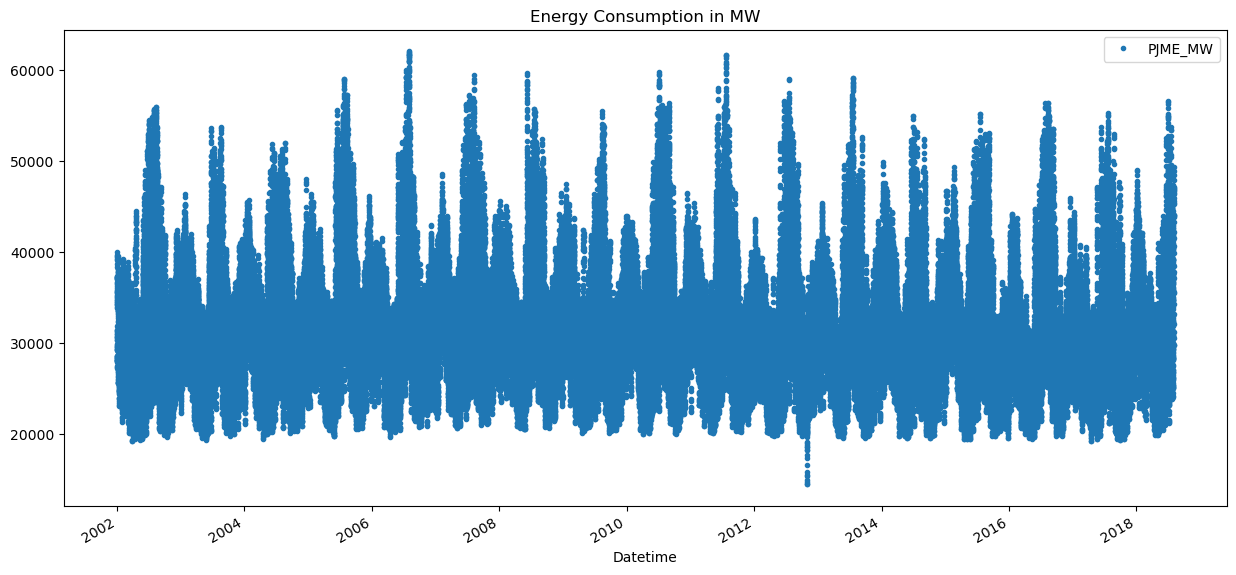

In [6]:
df.plot(style='.', figsize=(15,7), title='Energy Consumption in MW', color=color_pal[0])

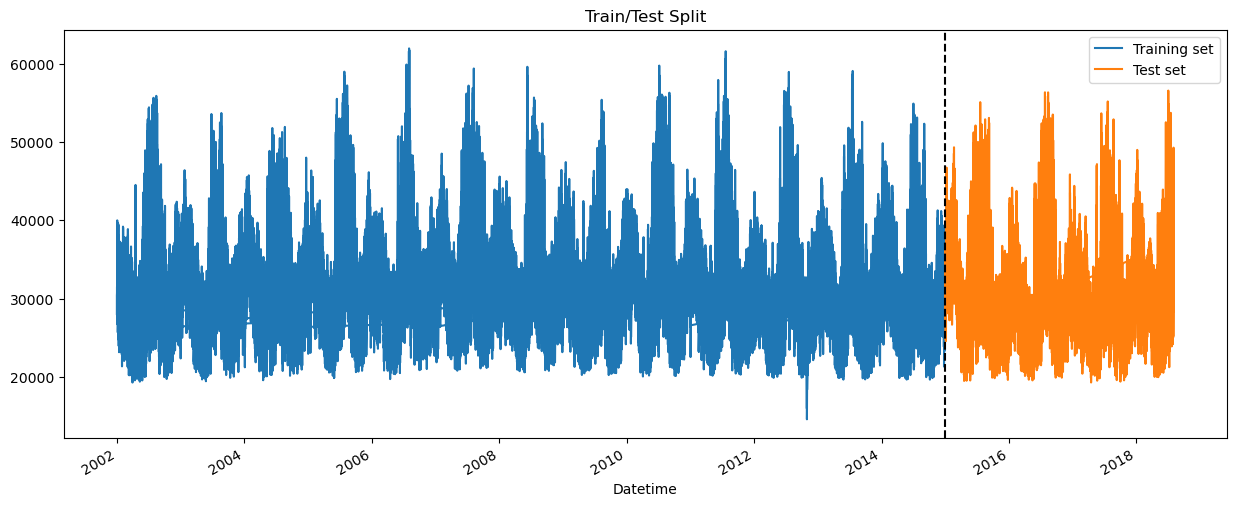

In [9]:
# train_test_split
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
df.head()

fig, ax = plt.subplots(figsize=(15, 6))

train.plot(ax=ax, label='Training set', title='Train/Test Split')
test.plot(ax=ax, label='Test set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training set', 'Test set'])
plt.show()

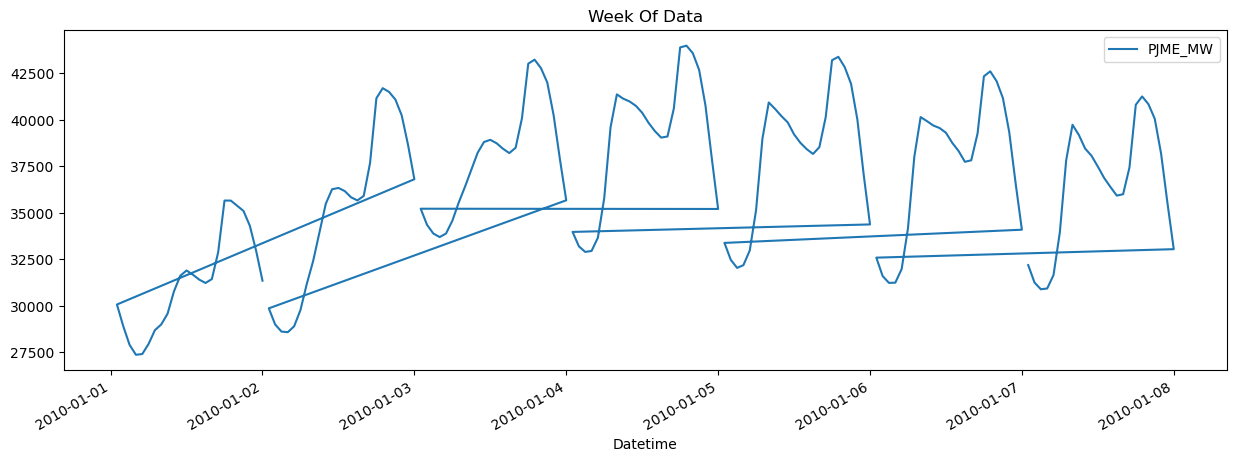

In [16]:
df.loc[(df.index >'01-01-2010') & (df.index <='01-08-2010')].plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [35]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['Month'] = df.index.month
    df['Hour'] = df.index.hour
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    
    return df

In [20]:
df = create_features(df)

In [21]:
df.head()

,PJME_MW,Month,Hour,Year,Quarter,dayofweek,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,12,1,2002,4,1,365
2002-12-31 02:00:00,25147.0,12,2,2002,4,1,365
2002-12-31 03:00:00,24574.0,12,3,2002,4,1,365
2002-12-31 04:00:00,24393.0,12,4,2002,4,1,365
2002-12-31 05:00:00,24860.0,12,5,2002,4,1,365


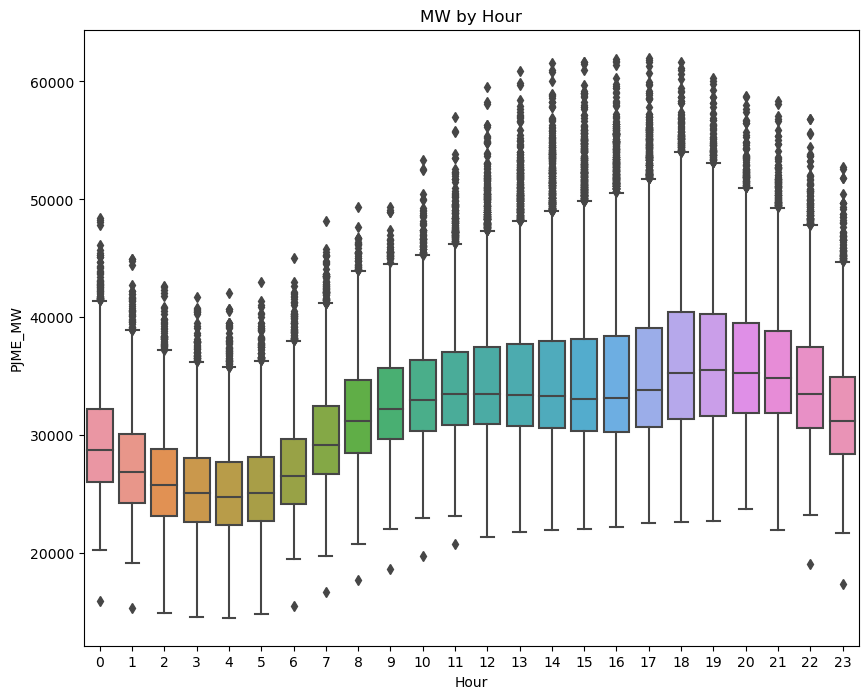

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

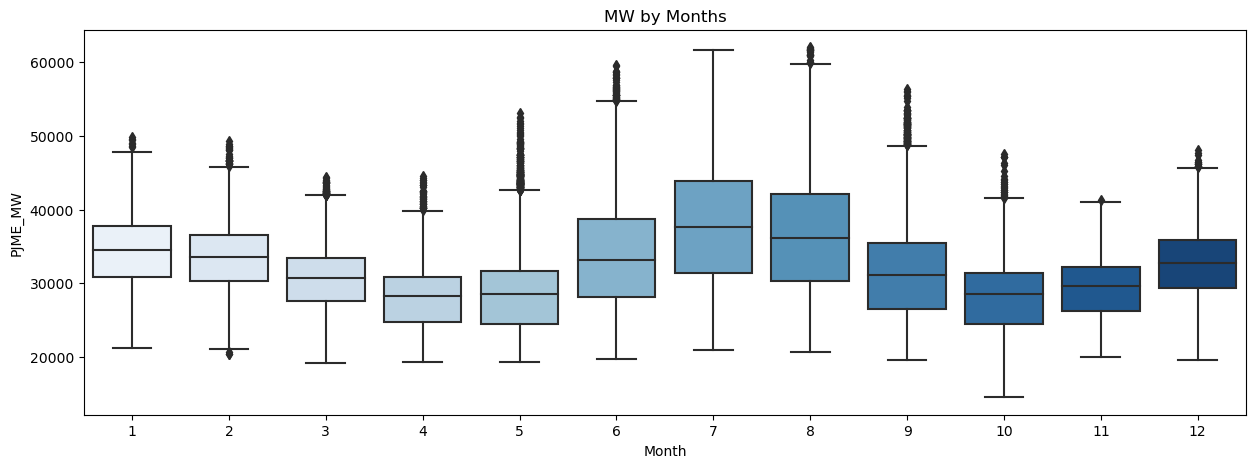

In [34]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='Month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Months')
plt.show()

In [36]:
df.columns

Index(['PJME_MW', 'Month', 'Hour', 'Year', 'Quarter', 'dayofweek',
       'dayofyear'],
      dtype='object')

In [43]:
train_set = create_features(train)
test_set = create_features(test)
features = ['Month', 'Hour', 'Year', 'Quarter', 'dayofweek','dayofyear']

x_train = train_set[features]
y_train = train_set['PJME_MW']

x_test = test_set[features]
y_test = test_set['PJME_MW']

In [51]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=1e-2, early_stopping_rounds=50)
xgb_reg.fit(x_train, y_train, 
            eval_set=[(x_train, y_train), (x_test, y_test)],
            verbose=1000)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [63]:
fi = pd.DataFrame(xgb_reg.feature_importances_,
            index=xgb_reg.feature_names_in_,
            columns=['Importance'])


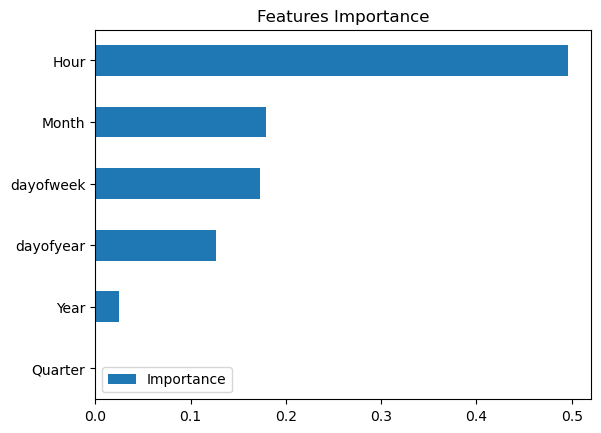

In [65]:
fi.sort_values('Importance').plot(kind='barh', title='Features Importance')
plt.show()

In [68]:
test_set['Prediction'] = xgb_reg.predict(x_test)

In [69]:
test_set

,PJME_MW,Month,Hour,Year,Quarter,dayofweek,dayofyear,Prediction
Datetime,,,,,,,,
2015-01-01 00:00:00,32802.0,1,0,2015,1,3,1,32393.351562
2015-12-31 01:00:00,24305.0,12,1,2015,4,3,365,29040.167969
2015-12-31 02:00:00,23156.0,12,2,2015,4,3,365,27877.017578
2015-12-31 03:00:00,22514.0,12,3,2015,4,3,365,27576.720703
2015-12-31 04:00:00,22330.0,12,4,2015,4,3,365,27576.720703
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,1,20,2018,1,0,1,38623.246094
2018-01-01 21:00:00,43751.0,1,21,2018,1,0,1,38495.484375
2018-01-01 22:00:00,42402.0,1,22,2018,1,0,1,36229.527344


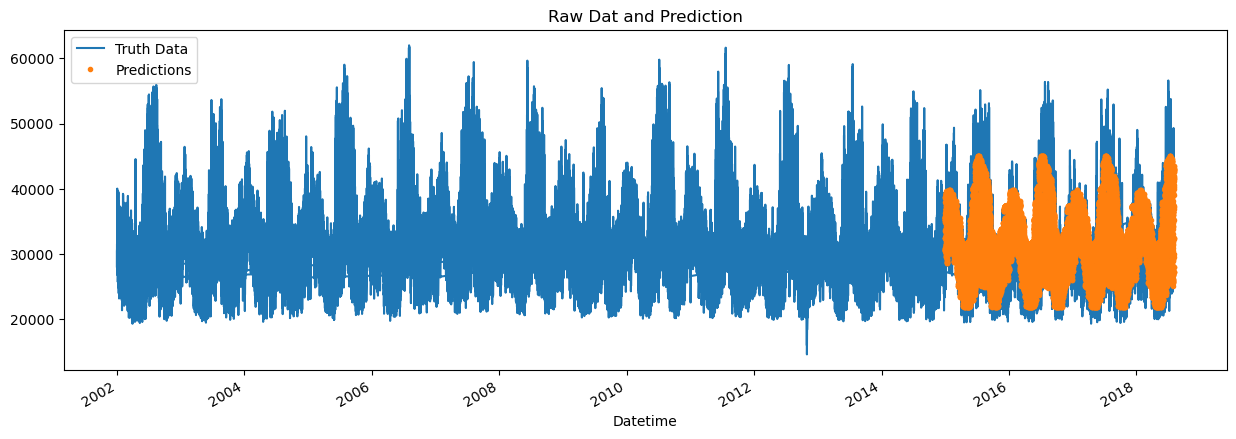

In [74]:
df = df.merge(test_set[['Prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['Prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

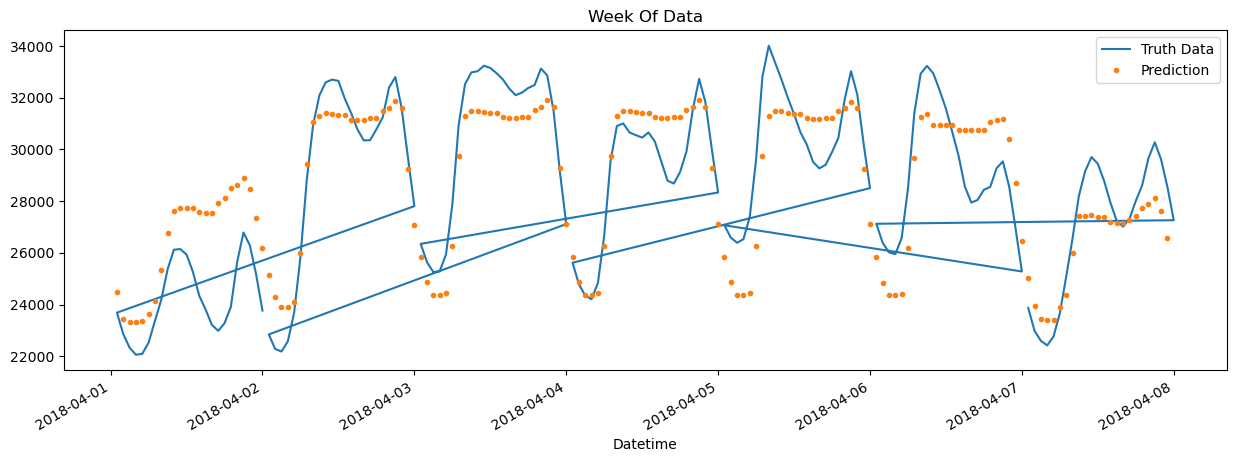

In [79]:
ax = df.loc[(df.index >'04-01-2018') & (df.index <='04-08-2018')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()
plt.show

In [86]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_set['PJME_MW'], test_set['Prediction'])
rmse = np.sqrt(mse)
rmse

3741.030178837441

In [84]:
test_set['error'] = np.abs(test_set['PJME_MW'] - test_set['prediction'])
test_set['date'] = test_set.index.date
test_set.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
2018-01-06    10407.698161
2015-02-20    10143.611491
2017-05-19     9495.122640
2016-07-04     9440.610596
2016-07-23     9362.332682
Name: error, dtype: float64

In [87]:
# Outliers

<Axes: ylabel='Frequency'>

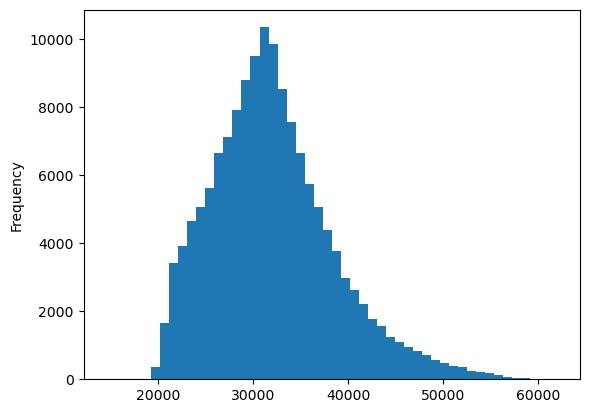

In [100]:
df['PJME_MW'].plot(kind='hist', bins=50)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

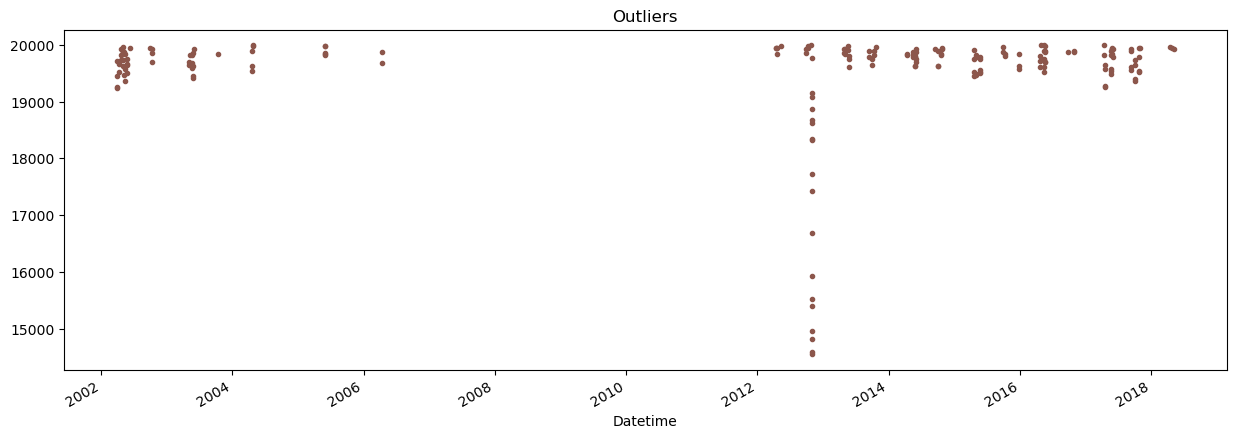

In [115]:
df.query('PJME_MW < 20000')['PJME_MW'].plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

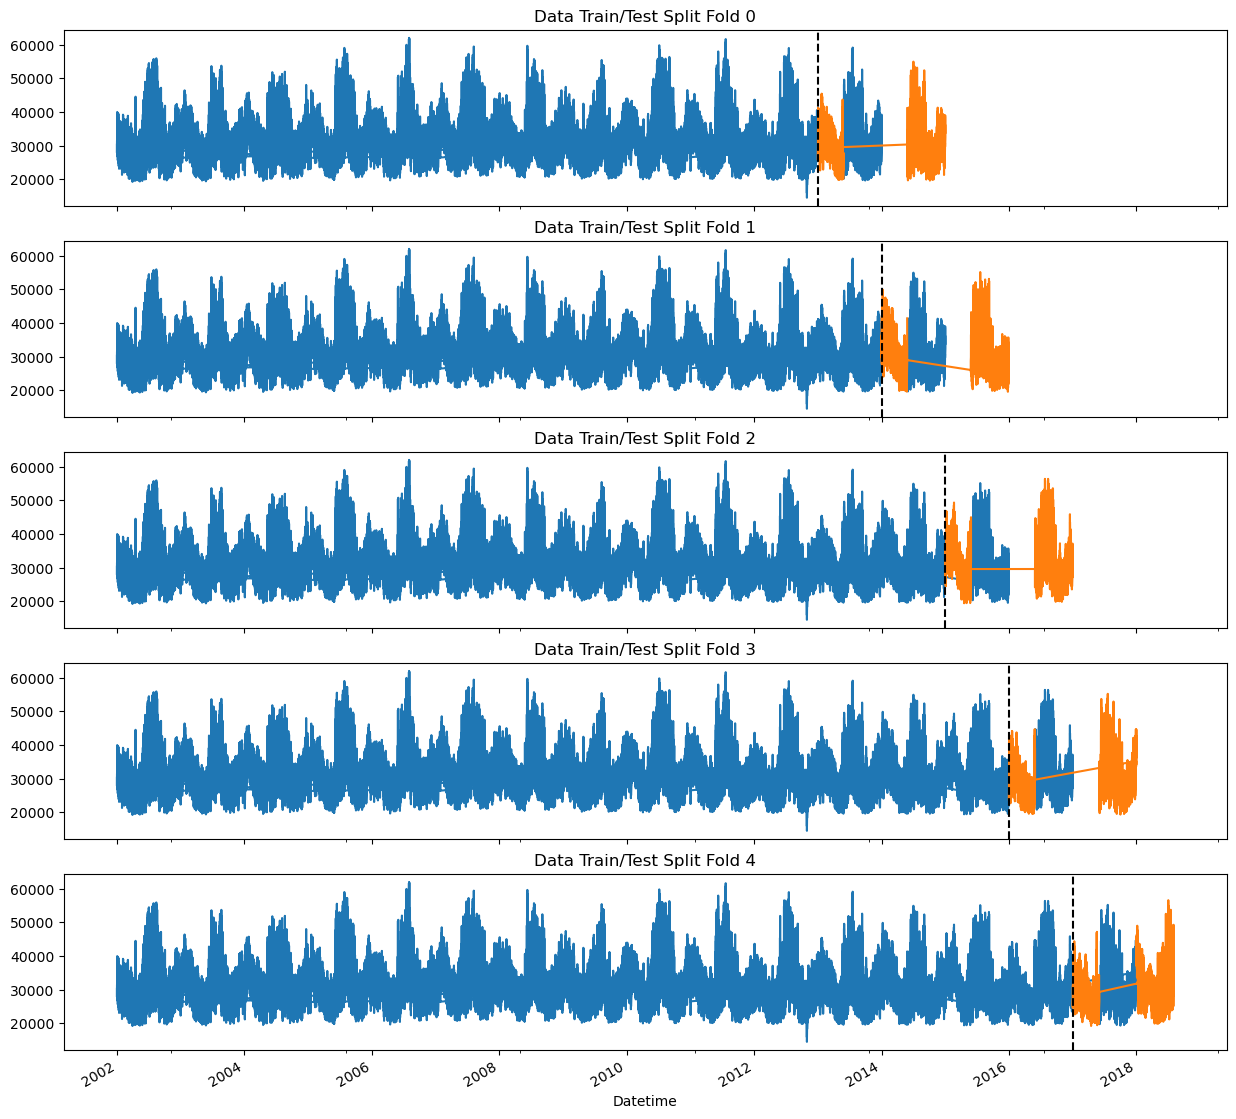

In [131]:

from sklearn.model_selection import TimeSeriesSplit



# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, test_idx in tscv.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    
    train['PJME_MW'].plot(ax=axs[fold], title=f'Data Train/Test Split Fold {fold}', label='Training Set')   
    test['PJME_MW'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), ls='--', color='black')
    
    fold += 1
plt.show()

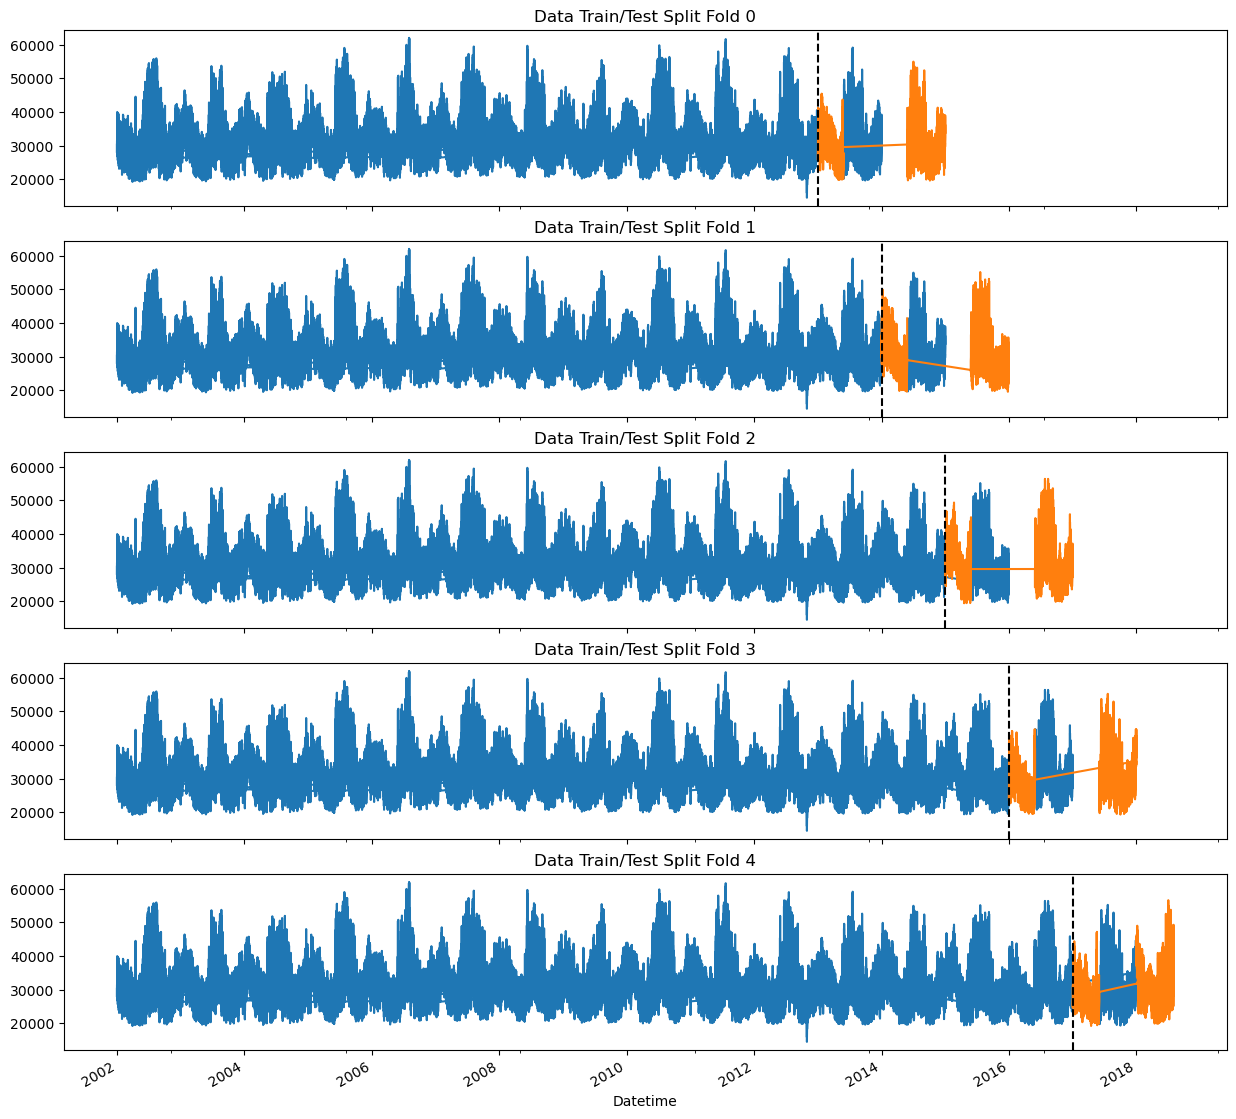

In [133]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tscv.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [134]:
pd.Timedelta('364 days')

Timedelta('364 days 00:00:00')

In [137]:
train.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2017-06-02 13:00:00', '2017-06-02 14:00:00',
               '2017-06-02 15:00:00', '2017-06-02 16:00:00',
               '2017-06-02 17:00:00', '2017-06-02 18:00:00',
               '2017-06-02 19:00:00', '2017-06-02 20:00:00',
               '2017-06-02 21:00:00', '2017-06-02 22:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=136672, freq=None)

In [141]:
train.index - pd.Timedelta('364 days')

DatetimeIndex(['2002-01-01 01:00:00', '2002-01-01 02:00:00',
               '2002-01-01 03:00:00', '2002-01-01 04:00:00',
               '2002-01-01 05:00:00', '2002-01-01 06:00:00',
               '2002-01-01 07:00:00', '2002-01-01 08:00:00',
               '2002-01-01 09:00:00', '2002-01-01 10:00:00',
               ...
               '2016-06-03 13:00:00', '2016-06-03 14:00:00',
               '2016-06-03 15:00:00', '2016-06-03 16:00:00',
               '2016-06-03 17:00:00', '2016-06-03 18:00:00',
               '2016-06-03 19:00:00', '2016-06-03 20:00:00',
               '2016-06-03 21:00:00', '2016-06-03 22:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=136672, freq=None)

In [152]:
# Sample time series data
data = {'Date': pd.date_range(start='2023-01-01', periods=5, freq='D'),
        'Value': [10, 20, 30, 40, 50]}
df_1 = pd.DataFrame(data)

In [159]:
df_1['lag'] = df_1['Value'].shift(1)

In [160]:
df_1

,Date,Value,lag
0,2023-01-01,10,NaN
1,2023-01-02,20,10.0
2,2023-01-03,30,20.0
3,2023-01-04,40,30.0
4,2023-01-05,50,40.0


In [164]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

AttributeError: 'RangeIndex' object has no attribute 'isocalendar'

In [165]:
import pandas as pd

# Example DataFrame
dates = pd.date_range(start='2022-01-01', periods=10, freq='D')
values = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
df = pd.DataFrame({'value': values}, index=dates)

# Create a target_map dictionary for illustration
target_map = {index: value for index, value in zip(df.index, df['value'])}

# Lag operation
df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)

print(df)


            value  lag1
2022-01-01    100   NaN
2022-01-02    110   NaN
2022-01-03    120   NaN
2022-01-04    130   NaN
2022-01-05    140   NaN
2022-01-06    150   NaN
2022-01-07    160   NaN
2022-01-08    170   NaN
2022-01-09    180   NaN
2022-01-10    190   NaN
